**Imports**

In [1]:
from imports import * 
from functions import *
from archs import *
from mylearner import *
%matplotlib inline
%load_ext tensorboard

**Loading data**

In [2]:
data_folder = '/scratch/smartairsense/data/'
csv_file = os.path.join(data_folder,'df_minimal_clean.csv')
df_chunks = pd.read_csv(csv_file,chunksize=100000,usecols=['humidity_abs','temperature','tvoc','oxygen','co2','co','no2','o3'],dtype=np.float32)

In [3]:
for i,df in enumerate(df_chunks):
    df.reset_index(drop=True,inplace= True)
    df.columns=df.columns
count = i+1

**Missing values, drop NaN**

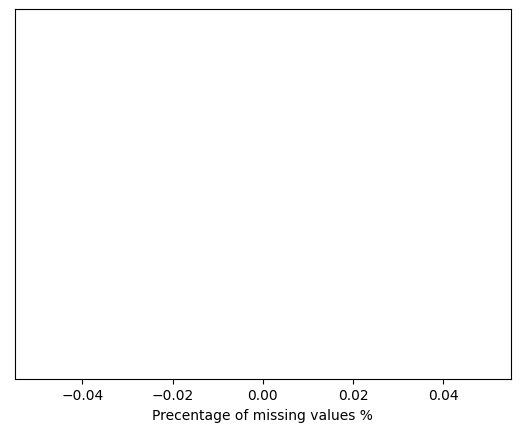

maximum number of missing values per column=  nan 

Empty DataFrame
Columns: [column, count, percentage]
Index: []


In [4]:
plot_missing(df)

#### substitute NaN values with mean 
## polynomial interpolation with degree > 1 uses index, also convert dtype to float to work
impute_NaN(df)

############## conmibe into df 

df.reset_index(drop=True,inplace= True)
df.columns=df.columns

**Sliding data**

In [5]:
with open('config.yaml') as f:
    hyperparams = yaml.load(f,SafeLoader)

under_window = hyperparams['sample_segment']['under_window']
seq_len = hyperparams['sample_segment']['seq_len']
stride = hyperparams['sample_segment']['stride']
sliding_mode = hyperparams['sample_segment']['sliding_mode']

X= sliding(seq_len,stride,df,mode=sliding_mode)
print(X.shape)

(99994, 8, 7)


**splitting and standardization**

In [6]:

###### splitting
# splits = TrainValidTestSplitter(valid_size=0.1,test_size=0.1)(y) ##### we have test set here
splits = TrainValidTestSplitter(valid_size=0.01)(X[:,0,0]) ##### we DON'T have test set here
x_train = np.zeros(X[splits[0]].shape,dtype=np.float32)
x_valid = np.zeros(X[splits[1]].shape,dtype=np.float32)
# x_test = np.zeros(X[splits[2]].shape,dtype=np.float32)
# y_test = y[splits[2]]

#################
scalers = {}
for i in range(x_train.shape[1]): ## n_features
    scalers[i] = StandardScaler()
    scalers[i].fit(np.unique((X[splits[0]])[:, i, :]).reshape(-1,1)) ### as we have overlapping samples
    x_train[:, i, :] = scalers[i].transform((X[splits[0]])[:, i, :].reshape(-1,1)).reshape(x_train.shape[0],x_train.shape[-1])
    x_valid[:, i, :] = scalers[i].transform((X[splits[1]])[:, i, :].reshape(-1,1)).reshape(x_valid.shape[0],x_valid.shape[-1])
    # x_test[:, i, :] = scalers[i].transform((X[splits[2]])[:, i, :].reshape(-1,1)).reshape(x_test.shape[0],x_test.shape[-1]) ## from splitting
print(x_train.shape,x_valid.shape)

(98995, 8, 7) (999, 8, 7)


**plotting distribution of data**

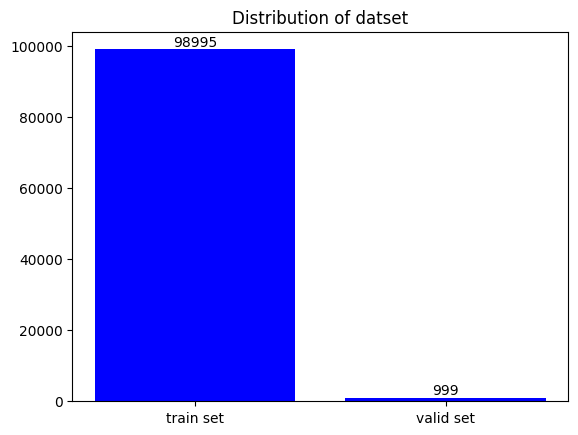

In [7]:
x_lbs = ['train set','valid set']
y_nmrs = [x_train.shape[0],x_valid.shape[0]]

fig, ax = plt.subplots()    
ind = np.arange(len(y_nmrs))  # the x locations for the groups
bars = ax.bar(ind, y_nmrs, color="blue")
ax.set_xticks(ind)
ax.set_xticklabels(x_lbs, minor=False)
plt.title('Distribution of datset')
# plt.xlabel('x')
# plt.ylabel('y')
ax.bar_label(bars)
plt.show()

**train cnn+lfstm autoencoder**

Load hyperparameters

In [8]:
with open('config.yaml') as f:
    hyperparams = yaml.load(f,SafeLoader)

epochs = hyperparams['model']['epochs']
bs = hyperparams['model']['bs']
num_workers = hyperparams['model']['num_workers']

Training

In [9]:
autoencoder = AutoEncoder(x_train.shape[1])


In [10]:
###training/validation dataloaders
Tsets = TSDatasets(x_train, inplace=True)
Vsets = TSDatasets(x_valid, inplace=True)
dls   = TSDataLoaders.from_dsets(Tsets, Vsets, bs = bs, num_workers=num_workers)#,batch_tfms=batch_tfms) ### note the normalization

autoencoder, history = train_autoencoder(
  autoencoder,
  dls.train,
  dls.valid,
  n_epochs=20
)

### save autoencoder
torch.save(autoencoder.state_dict(), f'models/{autoencoder._get_name()}.pt')


Epoch 1: train loss 0.2506571924521666 val loss 0.20020459266379476
Epoch 2: train loss 0.18645745393212776 val loss 0.17472344543784857
Epoch 3: train loss 0.16418143372646707 val loss 0.15364173892885447


**plot autoencoder train/valid losses**

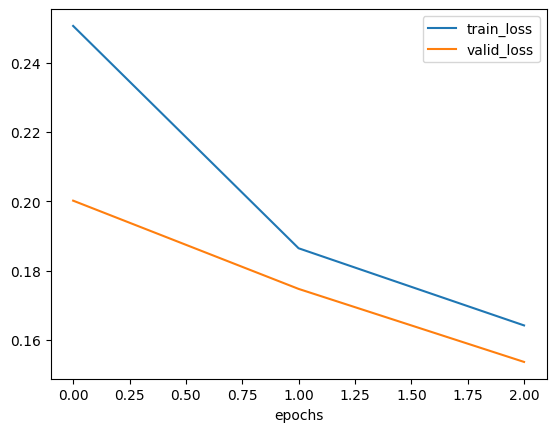

In [12]:
plt.figure()
plt.plot(history['train'],label='train_loss')
plt.plot(history['val'],label = 'valid_loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

**predict for autoencoder**

Correct normal predictions: 31/999


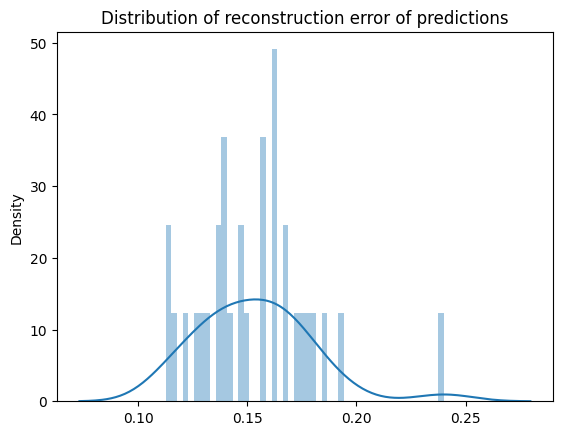

In [13]:
predictions, pred_losses = predict_autoencoder(autoencoder, dls.valid)
plt.figure()
sns.distplot(pred_losses, bins=50, kde=True)
plt.title('Distribution of reconstruction error of predictions')

### correct predictions based on threshold for reconstruction error
threshold = 0.2
correct = sum(l <= threshold for l in pred_losses)
print(f'Correct normal predictions: {correct}/{x_valid.shape[0]}')